IMPORTATION DES MODULES

In [26]:
# documentation of the API : 
# https://info.arxiv.org/help/api/user-manual.html#_calling_the_api
!pip install requests
import requests #

from xml.etree import ElementTree #pip install xml.etree # Pour lire les données extraites par l'api arXiv
import datetime as dt #pip install datetime #Pour convertir les dates de publicaiton de str en datetime pour les ranger par ordre chronologique

# 3 modules pour l'extraction du texte du pdf, manque tjrs les images...
import io
!pip install pdfminer.six
import pdfminer #pip install pdfminer
from pdfminer.high_level import extract_text  #pip install pdfminer.six

# pour analyse de sentiment
!pip install textblob
from textblob import TextBlob # #pip install textblob

# pour analyse mots clés
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Création de l'API, présentation

In [27]:
from flask import Flask, Response
!pip install matplotlib


app = Flask(__name__)

@app.route('/')
def index():
    return 'Présentation de notre API'



Appel à l'API et stockage des données dans une liste pour éviter de faire plein de fois le même appel pour la même requête.

In [28]:
def callAPI(urlreq, param):
    arxiv_url = urlreq
    research_type = param
    rep = requests.get(arxiv_url, params=research_type)
    root = ElementTree.fromstring(rep.content)
    return root

def articlesAPI():
    articles = []
    # Ici on défini notre url de requête et nos paramètres pour faire appel à l'api
    # On va chercher partout où le titre contient AI, et on garde 5 artciles comme dit la consigne
    root = callAPI("http://export.arxiv.org/api/query?",{"search_query": "all:ai", "max_results" : 5})
    # On regarde élément par élément dans notre recherche : le titre/l'abstract/le nom de l'auteur/
    #la date de publication/le lien pour accéder à l"article/l'identifiant associé
    for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
        title = entry.find('{http://www.w3.org/2005/Atom}title').text
        abs = entry.find('{http://www.w3.org/2005/Atom}summary').text
        auteur = entry.find('{http://www.w3.org/2005/Atom}author').find('{http://www.w3.org/2005/Atom}name').text
        published = entry.find('{http://www.w3.org/2005/Atom}published').text[0:10]
        link = entry.find('{http://www.w3.org/2005/Atom}id').text
        id = link[21:]
        urlpdf = f"http://arxiv.org/pdf/{id}"
        com = entry.find('{http://arxiv.org/schemas/atom}comment')
        com = com.text if com is not None else 'No comments'
        prim_cat = entry.find('{http://arxiv.org/schemas/atom}primary_category')
        prim_cat = prim_cat.attrib['term'] if prim_cat is not None else 'No primary category'

        articles.append([id, link, auteur, title, published, urlpdf, abs, prim_cat, com])

    for article in articles: # pour trier les artciles dans l'ordre chronologik ; pas trouvé comment faire avec l'api directement
        article[4] = dt.datetime.strptime(article[4], '%Y-%m-%d')
    articles.sort(key=lambda x: x[4], reverse = True)

    for i in articles :
        if i[7] == "cs.AI":
          i[7] = "IA"
        if i[7] == "cs.CR":
          i[7] = "Cryptographie"
        if i[7] == "cs.CY":
          i[7] = "Cybernétique"
    return articles

larticles = articlesAPI()

1ère route : get_data

récupère 5 liens d'articles et les range par ordre chronologique de sortie, puis les affiche

AMODIF, un peu nul

In [29]:
@app.route('/get_data')
def get_data():
    liste = larticles
    a = [i[7] +" : "+ i[1] for i in liste]
    html = "<br>".join(a)
    return Response(html, mimetype='text/html')

get_data()



<Response 239 bytes [200 OK]>

2ème route : Affiche les informations relatives aux 5 articles précédents, id, lien, auteur, titre, date de publi, lien pdf, abstract

In [30]:
@app.route('/articles')
def articles():
    art = larticles 
    commentaire = "Pour voir le contenu d'un article en particulier : modifier le chemin, /articles devient article/ID où ID est l'identifiant de l'article choisi"
    html = commentaire +  "<br>"+ "<br>".join([f"ID: {a[0]}<br>Link : {a[1]}<br>Authors : {a[2]}<br>Title : {a[3]}<br>Published : {a[4]}<br>PDF : {a[5]}<br>Summary : {a[6]}<br>catégorie : {a[7]}<br>Commentaires : {a[8]}<br>" for a in art])
    return Response(html, mimetype='text/html')



3ème route : Affiche le lien pdf et son contenu d'un article identifié par son id

In [31]:
def extractTEXTformPDF(id):
    urlpdf = f"http://arxiv.org/pdf/{id}"
    response = requests.get(urlpdf)
    
    text = (extract_text(io.BytesIO(response.content)), urlpdf)
    return text

@app.route('/article/<id>')

def article_content(id):

    text = extractTEXTformPDF(id)
    html_content = "Lien pour accéder au pdf direct : " + text[1] +'<br>'+'<br>'+'<br>' + text[0].replace('\n', '<br>')

    return Response(html_content, mimetype='text/html')


In [32]:
@app.route('/ml/<id>')
def analyze_sentiment_article(id):

    text = extractTEXTformPDF(id)

    blob = TextBlob(text[0])
    sentiment = blob.sentiment
    strpolarity = "polarity in [-1,1] ; avec <br> -1 : sentiment négatif <br> 0 : sentiment neutre <br> 1 sentiment positif "
    strsubj = "subjectivity in [0,1] ; avec <br> 0 : ocnmplétement objectif <br> 1 : complétement subjectif "

    html_content = strpolarity + '<br><br>' +  strsubj + '<br><br><br> polarity : ' + str(sentiment.polarity) + '<br> subjectivity : ' + str(sentiment.subjectivity)

    return Response(html_content, mimetype='text/html')

def get_keywords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in words if word not in stop_words and word.isalnum()]
    freq_dist = FreqDist(keywords)
    return freq_dist.most_common(10)

@app.route('/keywords/<id>')
def keywords_article(id):
    text = extractTEXTformPDF(id)[0]
    keywords = get_keywords(text)
    
    # Convertir la liste des mots-clés en HTML
    html_keywords = ''.join([f"<li>{word[0]}: {word[1]}</li>" for word in keywords])
    html_content = f"<ul>{html_keywords}</ul>"

    return Response(html_content, mimetype='text/html')
import matplotlib.pyplot as plt
import numpy as np

def generate_keywords_chart(id, keywords):
    # Assuming keywords is a list of tuples (word, frequency)
    words = [word[0] for word in keywords]
    frequencies = [word[1] for word in keywords]

    y_pos = np.arange(len(words))

    plt.figure(figsize=(10, 8))
    plt.barh(y_pos, frequencies, color='skyblue')
    plt.xlabel('Frequency')
    plt.title('Top 10 Keywords')
    plt.yticks(y_pos, words)
    plt.gca().invert_yaxis()  # To display the highest frequency word at the top
    plt.tight_layout()

    # Save the plot as a PNG file
    image_path = f'/mnt/data/keywords_{id}.png'
    plt.savefig(image_path)

    # Clear the current plot to free memory
    plt.clf()

    return image_path

@app.route('/keywords_visual/<id>')
def keywords_visual_article(id):
    text = extractTEXTformPDF(id)[0]
    keywords = get_keywords(text)

    # Generate and retrieve the path of the bar chart image
    image_path = generate_keywords_chart(id, keywords)
    
    # Serve the image as static file
    return f'<img src="{image_path}" alt="Keywords Visualization"/>'


In [38]:
!pip install wordcloud

def get_keywords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in words if word not in stop_words and word.isalnum()]
    return keywords  # Return all keywords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(id, keywords):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(keywords))
    plt.figure(figsize=(8, 4), dpi=100)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f'static/wordcloud_{id}.png', format='png')
    plt.close()
    return f'wordcloud_{id}.png'
@app.route('/keywords/<id>')
def keywords_article(id):
    text = extractTEXTformPDF(id)[0]
    keywords = get_keywords(text)
    # Count the frequency of each word
    freq_dist = FreqDist(keywords)
    # Sort the words by frequency in descending order
    sorted_keywords = sorted(freq_dist.items(), key=lambda x: x[1], reverse=True)
    
    # Convert the sorted list of word frequencies into an HTML formatted string
    html_keywords = ''.join([f"<li>{word[0]}: {word[1]}</li>" for word in sorted_keywords])
    html_content = f"<h2>Most Common Words</h2><ul>{html_keywords}</ul>"
    
    return Response(html_content, mimetype='text/html')



AssertionError: View function mapping is overwriting an existing endpoint function: keywords_article

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [07/Apr/2024 16:51:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2024 16:51:46] "GET /articles HTTP/1.1" 200 -
127.0.0.1 - - [07/Apr/2024 16:51:59] "GET /article/2403.05551v1 HTTP/1.1" 200 -
[2024-04-07 16:52:09,958] ERROR in app: Exception on /wordcloud/2403.05551v1 [GET]
Traceback (most recent call last):
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\flask\app.py", line 1463, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\flask\app.py", line 872, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\flask\app.py", line 870, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File 

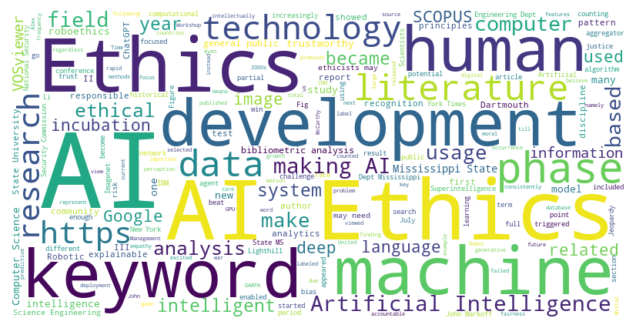

In [37]:
# faire tourner le serveur

if __name__ == '__main__':
    app.run()